### Loading data

In [1]:
#Import packages
print("Scanpy: Importing packages")
import numpy as np
import pandas as pd
import scanpy.api as sc
import timeit
import os
import seaborn as sns
import matplotlib.pyplot as plt
from statannot import add_stat_annotation

# Import scoreCT helper functions
import sys
sys.path.append('/Users/lucas/scoreCT/src/')
import scorect_api as ct

# Read Data
adata = sc.read('files/organoid_raw_wk2wk5.h5ad')
print(adata.shape)
adata.var_names_make_unique()

Scanpy: Importing packages


/Users/lucas/anaconda3/lib/python3.6/site-packages/numba/decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)
/Users/lucas/anaconda3/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(7650, 59042)


## Preprocessing


In [2]:
#### PARAMETERS FOR GATING CELLS #####
thrsh_mito=0.2
up_thrsh_genes=6000
low_thrsh_genes=50
print("Will filter out cells with more than",thrsh_mito,"percent of mitochondrial genes")
print("Will filter out cells with less than", low_thrsh_genes, "and more than", up_thrsh_genes, "genes")

#Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
#Computing percentage of mitochondrial genes
mito_genes = [name for name in adata.var_names if name.startswith('MT.') or name.startswith('MT-')]
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs['n_counts'] = np.sum(adata.X, axis=1)

#Filtering out cells according to filter parameters
print('Scanpy: Filtering cells')
adata = adata[adata.obs['n_genes'] < up_thrsh_genes, :]
adata = adata[adata.obs['n_genes'] > low_thrsh_genes, :]
adata = adata[adata.obs['percent_mito'] < thrsh_mito, :]

#Get logarithmirized raw gene exression
adata_raw = sc.pp.log1p(adata, copy=True)
adata.raw = adata_raw

#Per-cell normalization step, Identification of highly variable genes and filtering
#Normalize using 10000 as a factor
print('Scanpy: Normalization step')
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

#Finding variable genes & filtering out others
print('Scanpy: finding highly variable genes')
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
#fig=sc.pl.filter_genes_dispersion(filter_result)
adata = adata[:, filter_result.gene_subset]

#Log data
sc.pp.log1p(adata)

#Regress out variables nUMI and percent_mito, you can add 'batch' for BATCH CORRECTION (not useful here)
print('Scanpy: Regressing out variables')
sc.pp.regress_out(adata, ['n_counts','percent_mito'])

#Print number of highly variable genes
print('Number of variable genes identified:', adata.shape[1])

sc.pp.scale(adata, max_value=10)

Will filter out cells with more than 0.2 percent of mitochondrial genes
Will filter out cells with less than 50 and more than 6000 genes


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Scanpy: Filtering cells
Scanpy: Normalization step
Scanpy: finding highly variable genes


/Users/lucas/anaconda3/lib/python3.6/site-packages/scanpy/preprocessing/_simple.py:298: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


Scanpy: Regressing out variables
Number of variable genes identified: 4623


## Load cell types and DE gene list

In [5]:
meta_cells = pd.read_csv('files/celltypes_wk2wk5_names.csv', sep=',', index_col=0)
common_names = list(set(adata.obs.index.tolist()).intersection(set(meta_cells.index.tolist())))
mask_out = np.isin(adata.obs.index.tolist(), common_names)
meta_cells = meta_cells[np.isin(meta_cells.index.tolist(), common_names)]
adata = adata[mask_out,:].copy()
meta_cells = meta_cells.reindex(adata.obs.index.tolist())
#adata.obs['cell_type'] = [' '.join(i.split(' ')[1:]) for i in meta_cells['cell_type'].tolist()]
adata.obs['cell_type'] = meta_cells['cell_type'].tolist()

In [8]:
# Read files
gene_list= []
with open('files/DE.UpinK.inOrganoids.041920.txt') as file:
    lines = file.readlines()
    for line in lines:
        line = line.strip()
        if 'limma' not in line:
            gene_list.append(line)
file.close()

### DEG for cell types and rank analysis

In [9]:
# Run scanpy DEG with t-test overestim var
sc.tl.rank_genes_groups(adata, groupby='cell_type', n_genes=len(adata.raw.var), method='t-test_overestim_var')
ranked_genes = ct.wrangle_ranks_from_anndata(adata)


dict_cell_data = {}
cell_types = np.unique(adata.obs['cell_type'])
# Loop over cell types to get ranks
for cell in cell_types:
    data = ranked_genes[ranked_genes['cluster_number']==cell]
    # Get median
    ranks = [data[data['gene']==lnc].index[0] for lnc in set(gene_list).intersection(set(data['gene']))]
    ranks = ((len(data))-np.array(ranks))/(len(data))
    dict_cell_data[cell] = ranks

# Plot with seaborn
res_df = pd.DataFrame(dict_cell_data)
res_df = res_df.rename(columns={'Neuroepithelium':'Neural\nepithelium',
                             'Early radial glia':'Early\nradial Glia',
                            'Intermediate Progenitors':'Intermediate\nprogenitors',
                            'Late radial glia':'Late\nradial Glia',
                            'Neurons':'Neurons'})

... storing 'cell_type' as categorical


Wrangling: Number of markers used in ranked_gene_groups:  31671
Wrangling: Groups used for ranking: cell_type


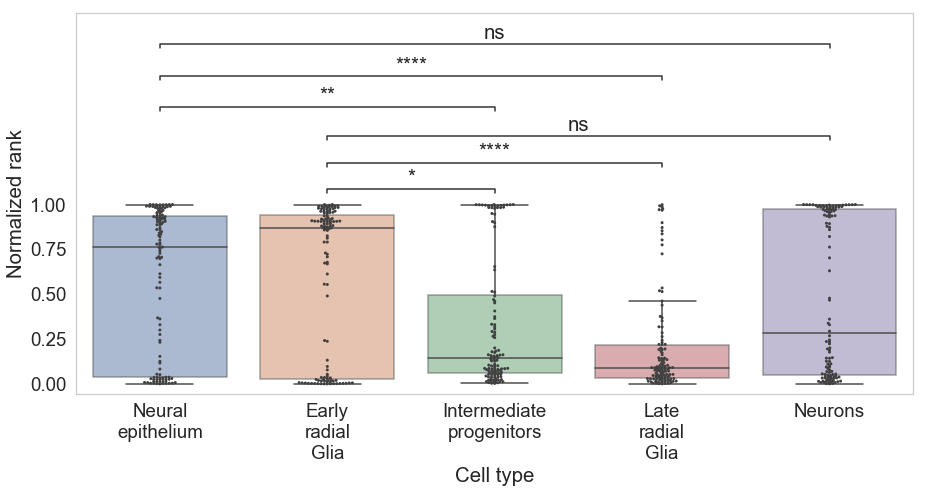

In [10]:
ordered_labels = ['Neural\nepithelium','Early\nradial Glia', 'Intermediate\nprogenitors', 'Late\nradial Glia', 'Neurons']
res_df = res_df.reindex(columns=ordered_labels)
sns.set(font_scale=1.7)
sns.set_style("whitegrid", {'axes.grid' : False})
res_df.rename(columns={ct:'\n'.join(ct.split(' ')) if '-' not in ct else '\n'.join(ct.split('-')) for ct in ordered_labels}, inplace=True)
fig = plt.figure(figsize=[15,7])
ax = sns.boxplot(data=res_df, boxprops=dict(alpha=.5), showfliers=False)
ax = sns.swarmplot(data=res_df, color='.25', size=3)
#fig = plt.gcf()
test_results = add_stat_annotation(ax, res_df, box_pairs=[('Early\nradial\nGlia','Intermediate\nprogenitors'),
                                                          ('Early\nradial\nGlia','Late\nradial\nGlia'),
                                                          ('Early\nradial\nGlia','Neurons'),
                                                          ('Neural\nepithelium','Intermediate\nprogenitors'),
                                                          ('Neural\nepithelium','Late\nradial\nGlia'),
                                                          ('Neural\nepithelium','Neurons')
                                                         ],
                                  test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
#ax.set_title('DE up in K rankings')
#ax.set_ylim([0,1.1])
ax.set_ylabel('Normalized rank')
ax.set_xlabel('Cell type')
ax.set_yticks(ticks=np.linspace(0,1, 5))
#plt.savefig('celltype_ranks_box.png', format='png', dpi=600, bbox_inches = "tight")